# Project 3 - Graph Algorithm Implementation

University of California, Berkeley

Master of Information and Data Science (MIDS) program

w205 - Fundamentals of Data Engineering


# Implementation of Betweeness Centrality Graph Algorithm

Betweeness Centrality compute all pairs shortest path (weighted). For each node, compute how many paths pass through the node. The pivotal node lies on every path between two other nodes. In this implemenation, we would place a backup delivery struck at the stations with the highest betweeness scores so that there a fail safe system in case that station is down for the day. 

In [1]:
import neo4j

import csv

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import psycopg2

from geographiclib.geodesic import Geodesic

# use seaborn aesthetic 
plt.rcParams.update({'font.size': 14})
sns.set_style("whitegrid", {'axes.grid' : False})

In [2]:
driver = neo4j.GraphDatabase.driver(uri="neo4j://neo4j:7687", auth=("neo4j","w205"))

In [3]:
session = driver.session(database="neo4j")

In [4]:
def my_neo4j_run_query_pandas(query, **kwargs):
    "run a query and return the results in a pandas dataframe"
    
    result = session.run(query, **kwargs)
    
    df = pd.DataFrame([r.values() for r in result], columns=result.keys())
    
    return df

In [5]:
# since the BART systems looked connected,
# we will be using gds page rank algorithm to rank all of the given station and output it in a tabular format
query = "CALL gds.graph.drop('ds_graph', false)"
session.run(query)

query = "CALL gds.graph.project('ds_graph', 'Station', 'LINK', {relationshipProperties: 'weight'})"
session.run(query)

In [6]:
query = """

CALL gds.betweenness.stream('ds_graph')
YIELD nodeId, score
RETURN gds.util.asNode(nodeId).name AS name, score as betweenness
ORDER BY betweenness DESC

"""

df = my_neo4j_run_query_pandas(query)
df = df[df['betweenness'] > 0]
df['name'] = [" ".join(n[1:]) for n in df['name'].str.split(" ")] # remove the line
df = df.groupby('name').mean().reset_index().sort_values('betweenness', ascending=False)
df = df.head(10)
df

,name,betweenness
39,Rockridge,5509.000000
33,Orinda,4997.000000
24,Lafayette,4469.000000
0,12th Street,4176.426217
26,MacArthur,4138.430736
25,Lake Merritt,3988.568790
46,Walnut Creek,3925.000000
2,19th Street,3888.013767
21,Fruitvale,3697.419834
49,West Oakland,3476.772638


# Determining the Zipcodes within High Betweeness Station

let's first import some supporting code to calculate a box radius from a given zipcode


In [7]:
def my_calculate_box(point, miles):
    "Given a point and miles, calculate the box in form left, right, top, bottom"
    
    geod = Geodesic.WGS84

    kilometers = miles * 1.60934
    meters = kilometers * 1000

    g = geod.Direct(point[0], point[1], 270, meters)
    left = (g['lat2'], g['lon2'])

    g = geod.Direct(point[0], point[1], 90, meters)
    right = (g['lat2'], g['lon2'])

    g = geod.Direct(point[0], point[1], 0, meters)
    top = (g['lat2'], g['lon2'])

    g = geod.Direct(point[0], point[1], 180, meters)
    bottom = (g['lat2'], g['lon2'])
    
    return(left, right, top, bottom)

In [8]:
def my_station_get_zips(station, miles):
    "given a station, pull all zip codes with miles distance, print them, sum the population"
    
    connection.rollback()
    
    query = "select latitude, longitude from stations "
    query += "where station = '" + station + "'"
    
    cursor.execute(query)
    
    connection.rollback()
    
    rows = cursor.fetchall()
    
    for row in rows:
        latitude = row[0]
        longitude = row[1]
        
    point = (latitude, longitude)
        
    (left, right, top, bottom) = my_calculate_box(point, miles)
    
    query = "select zip, population from zip_codes "
    query += " where latitude >= " + str(bottom[0])
    query += " and latitude <= " + str(top [0])
    query += " and longitude >= " + str(left[1])
    query += " and longitude <= " + str(right[1])
    query += " order by 1 "

    cursor.execute(query)
    
    connection.rollback()
    
    rows = cursor.fetchall()
    
    print("\n-------------------------------------------------------------------------------")
    print("  Zip Codes within " + str(miles) + " mile(s) of " + station + " BART Station")
    print("-------------------------------------------------------------------------------\n")
    
    total_population = 0
    
    zip_codes = []
    for row in rows:
        zip = row[0]
        population = row[1]
        print("     zip:", zip, "  population: ", f'{population:10,}')
        total_population += population
        zip_codes.append((zip, population))
    
    print("\n-------------------------------------------------------------------------------")
    print("  Total Population: ", f'{total_population:10,}')
    print("-------------------------------------------------------------------------------")
    
    return int(total_population), zip_codes

In [9]:
connection = psycopg2.connect(
    user = "postgres",
    password = "ucb",
    host = "postgres",
    port = "5432",
    database = "postgres"
)

In [10]:
cursor = connection.cursor()

In [11]:
# let's try to get 3 miles radius population from each station
populations_3 = []
populations_5 = []

for station in df.name:
    total_population, zip_codes = my_station_get_zips(station, 3)
    populations_3.append(total_population)

    total_population, zip_codes = my_station_get_zips(station, 5)
    populations_5.append(total_population)

df['total_pop_3_miles'] = populations_3
df['total_pop_5_miles'] = populations_5


-------------------------------------------------------------------------------
  Zip Codes within 3 mile(s) of Rockridge BART Station
-------------------------------------------------------------------------------

     zip: 94602   population:      29,933
     zip: 94607   population:      26,254
     zip: 94608   population:      30,289
     zip: 94609   population:      22,811
     zip: 94610   population:      31,496
     zip: 94611   population:      39,384
     zip: 94612   population:      16,062
     zip: 94618   population:      17,041
     zip: 94702   population:      17,092
     zip: 94703   population:      21,937
     zip: 94704   population:      29,190
     zip: 94705   population:      13,365
     zip: 94709   population:      11,740
     zip: 94710   population:       7,461
     zip: 94720   population:       2,971

-------------------------------------------------------------------------------
  Total Population:     317,026
----------------------------------------


-------------------------------------------------------------------------------
  Zip Codes within 5 mile(s) of 19th Street BART Station
-------------------------------------------------------------------------------

     zip: 94501   population:      63,843
     zip: 94502   population:      14,619
     zip: 94563   population:      19,341
     zip: 94601   population:      52,299
     zip: 94602   population:      29,933
     zip: 94603   population:      34,593
     zip: 94606   population:      38,303
     zip: 94607   population:      26,254
     zip: 94608   population:      30,289
     zip: 94609   population:      22,811
     zip: 94610   population:      31,496
     zip: 94611   population:      39,384
     zip: 94612   population:      16,062
     zip: 94613   population:         861
     zip: 94618   population:      17,041
     zip: 94621   population:      35,287
     zip: 94702   population:      17,092
     zip: 94703   population:      21,937
     zip: 94704   populat

In [12]:
df

,name,betweenness,total_pop_3_miles,total_pop_5_miles
39,Rockridge,5509.000000,317026,536232
33,Orinda,4997.000000,32706,262181
24,Lafayette,4469.000000,52373,202640
0,12th Street,4176.426217,298398,510498
26,MacArthur,4138.430736,271301,524629
25,Lake Merritt,3988.568790,281357,542120
46,Walnut Creek,3925.000000,91133,215621
2,19th Street,3888.013767,298398,576172
21,Fruitvale,3697.419834,317296,544423
49,West Oakland,3476.772638,229058,473317


<Figure size 432x288 with 0 Axes>

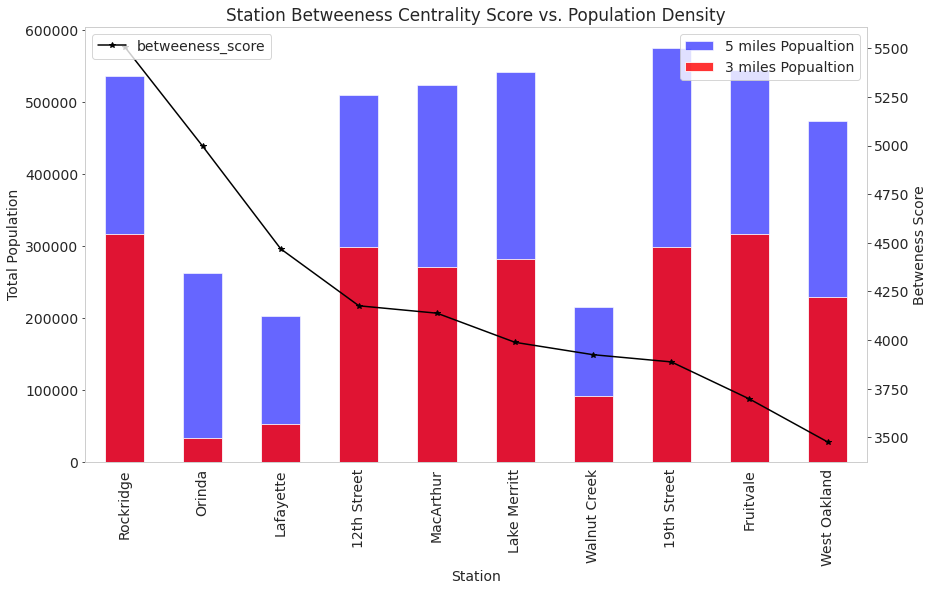

In [14]:
# plot some population data vs the betweeness
plt.clf()
fig, ax = plt.subplots(figsize=(14,8))
ax2 = ax.twinx()
df.plot(x ='name', y='total_pop_5_miles', kind='bar', color='blue', alpha=0.6, ax = ax, label="5 miles Popualtion")
df.plot(x ='name', y='total_pop_3_miles', kind='bar', color='red', alpha=0.8, ax = ax, label="3 miles Popualtion")
df.plot(x = 'name', y='betweenness', kind='line', marker="*", color='black', ax = ax2, label="betweeness_score")
ax.set_xlabel("Station")
ax.set_ylabel("Total Population")
ax2.set_ylabel("Betweness Score")
ax.legend(loc='upper right')
ax2.legend(loc='upper left')
ax.set_title("Station Betweeness Centrality Score vs. Population Density")
plt.show()